In [ ]:
!pip install mnist

In [ ]:
import sys
import os

# Ensure the current directory is in the Python path
sys.path.append(os.path.dirname(os.path.abspath('mnist_loader.py')))

In [ ]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()


In [ ]:
pip install nnfs

In [ ]:
#final softmax implimentation
import matplotlib.pyplot as plt
import numpy as np
import nnfs
import math
nnfs.init
np.random.seed(0)
training_data = list(training_data)
X , y = zip(*training_data)

X = np.array(X)
X = X.reshape(50000 , 784)
y = np.array(y)
y = y.reshape(50000 , 10)

class Activation_ReLU:
  def forward(self , input):
    self.output = np.maximum(0 , input)

    self.inputs = input #here inputs are z(sum funct.)
  # backward pass
  def backward(self , dvalues):
  # with chain rule
    self.dinputs = dvalues.copy()
  # Zero gradient where input values were negative
    self.dinputs[self.inputs <= 0] = 0

class Activation_Softmax:
  def forward(self , inputs):
    exp_values = np.exp(inputs - np.max(inputs , axis=1 , keepdims = True))
    probabilities = exp_values / np.sum(exp_values , axis =1  , keepdims= True)  #axis 1 mean sum is sum of neurons for the same batch
    self.output = probabilities

    #backward
  def backward(self , dvalues):
    self.dinputs = np.empty_like(dvalues)

    for index, (single_output , single_dvalues) in enumerate(zip(self.output , dvalues)):
      single_output = single_output.reshape(-1, 1)
      jacobian_matrix = np.diagflat(single_output) - np.dot(single_output , single_output.T)
      self.dinputs[index] = np.dot(single_dvalues , jacobian_matrix)


class layer_dense :
  def __init__(self , n_inputs , n_neurons):
    self.weights = 0.10*np.random.randn(n_inputs , n_neurons )
    self.biases = np.zeros((1 , n_neurons))
  def forward(self , input):
    self.output = np.dot(input , self.weights) + self.biases
    self.inputs = input
  # backward pass
  def backward(self, dvalues):
    # gradient on parameters
    self.dweights = np.dot(self.inputs.T , dvalues)
    self.dbiases = np.sum(dvalues, axis =0 , keepdims = True)
    # gradient on values
    self.dinputs = np.dot(dvalues , self.weights.T)

class Loss:
  def calculate(self , output , y):
    loss_values = self.forward(output , y)
    mean_loss = np.mean(loss_values)    #updated maths example
    return mean_loss

class Loss_CategoricalCrossEntropy(Loss):
  def forward(self , y_pred , y_true):
    sample_len = len(y_pred)
    clipped_pred = np.clip(y_pred , 1e-7 , 1-1e-7) # [1,2,3,4,5,6,7] cliped in range(2 , 5) ----> [2,2,3,4,5,5,5]

    if len(y_true.shape) == 1: #class targets
      correct_confidences = clipped_pred[range(sample_len) , y_true]

    elif len(y_true.shape) == 2:
      correct_confidences = np.sum(clipped_pred * y_true , axis = 1)

    entropy_loss  = - np.log(correct_confidences)
    return entropy_loss

  #backpropagation
  def backward(self , dvalues , y_true):
    # Number of samples
    samples = len(dvalues)
    # Number of labels in every sample
    labels = len(dvalues[0])
    #if lables are sparse , turn them into onehot vector
    if len(y_true.shape)== 1 :
      y_true = np.eye(labels)[y_true]

    #calculating gradient
    self.dinputs = - y_true / dvalues
    # normalizing gradient kuki gradient zada bada hoga toh step bhi bohot zada bada hojayega
    # helps mitigate issues related to varying batch sizes or individual samples having disproportionately large or small loss values.
    # , we’ll have to adjust the learning rate according to each set of samples to compensate we do this step #an updated maths concept
    self.dinputs = self.dinputs / samples

class Activation_Softmax_Loss_CategoricalCrossentropy():
  # Creates activation and loss function objects
  def __init__(self):
    self.activation = Activation_Softmax()
    self.loss = Loss_CategoricalCrossEntropy()

  # forward
  def forward(self , inputs , y_true): # here inputs are z
    # output layer activation function
    self.activation.forward(inputs)
    self.output = self.activation.output
    # calculate and return loss value
    return self.loss.calculate(self.output , y_true)

  def backward(self , dvalues , y_true):
    samples = len(dvalues)
     # If labels are one-hot encoded,
     # turn them into discrete values because its easier to handle in this case
    if len(y_true.shape) == 2:
      y_true = np.argmax(y_true , axis = 1)

    self.dinputs = dvalues.copy()
    # calculate gradient
    self.dinputs[range(samples) , y_true] -= 1
    # normalize gradient
    self.dinputs = self.dinputs / samples

class Optimizer_SGD():
  def __init__(self , learning_rate = 0.2):
    self.Learning_rate = learning_rate

  def update_params(self , layer):
    layer.weights -= self.Learning_rate * layer.dweights
    layer.biases -= self.Learning_rate * layer.dbiases

optimizer = Optimizer_SGD()

layer1 = layer_dense(784 , 784)
layer2 = layer_dense(784 , 50)
layer3 = layer_dense(50 , 10)

activation1 = Activation_ReLU()
activation2 = Activation_ReLU()
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

losses = []
accuracies = []

for epoch in range(30):
  layer1.forward(X)
  activation1.forward(layer1.output)
  output1 = activation1.output

  layer2.forward(output1)
  activation2.forward(layer2.output)
  output2 = activation2.output

  layer3.forward(output2)
  loss = loss_activation.forward(layer3.output , y) #softmax and loss is cal. and loss is returned
  output3 = loss_activation.output

  #Calculate accuracy from output of activation2 and targets
  #calculate values along the first axis
  predictions = np.argmax(output3 , axis =1) #correct predictions here we dont care about the values of prediction just about whether the neuron got activated or not
  if len(y.shape) == 2:
    y = np.argmax(y , axis = 1)
  accuracy = np.mean(predictions == y)


  if not epoch % 1:
    print(f'epoch: {epoch}, '+
          f'acc: {accuracy:.3f}, '+
          f'loss: {loss:.3f}')

  losses.append(loss)
  accuracies.append(accuracy)

  #backpropagation
  loss_activation.backward(output3, y)
  layer3.backward(loss_activation.dinputs)
  activation2.backward(layer3.dinputs)
  layer2.backward(activation2.dinputs)
  activation1.backward(layer2.dinputs)
  layer1.backward(activation1.dinputs)

  optimizer.update_params(layer1)
  optimizer.update_params(layer2)
  optimizer.update_params(layer3)


epoch: 0, acc: 0.089, loss: 2.607
epoch: 1, acc: 0.188, loss: 2.210
epoch: 2, acc: 0.352, loss: 1.986
epoch: 3, acc: 0.487, loss: 1.787
epoch: 4, acc: 0.544, loss: 1.598
epoch: 5, acc: 0.598, loss: 1.465
epoch: 6, acc: 0.479, loss: 1.513
epoch: 7, acc: 0.458, loss: 2.004
epoch: 8, acc: 0.540, loss: 1.552
epoch: 9, acc: 0.604, loss: 1.313
epoch: 10, acc: 0.645, loss: 1.206
epoch: 11, acc: 0.751, loss: 0.955
epoch: 12, acc: 0.757, loss: 0.867
epoch: 13, acc: 0.773, loss: 0.817
epoch: 14, acc: 0.735, loss: 0.829
epoch: 15, acc: 0.713, loss: 0.884
epoch: 16, acc: 0.669, loss: 0.916
epoch: 17, acc: 0.693, loss: 0.994
epoch: 18, acc: 0.792, loss: 0.686
epoch: 19, acc: 0.807, loss: 0.637
epoch: 20, acc: 0.820, loss: 0.600
epoch: 21, acc: 0.819, loss: 0.591
epoch: 22, acc: 0.808, loss: 0.592
epoch: 23, acc: 0.787, loss: 0.637
epoch: 24, acc: 0.756, loss: 0.707
epoch: 25, acc: 0.738, loss: 0.757
epoch: 26, acc: 0.731, loss: 0.831
epoch: 27, acc: 0.797, loss: 0.649
epoch: 28, acc: 0.817, loss: 0

In [ ]:
test_data = list(test_data)

X , y = zip(*test_data)

X = np.array(X)
X = X.reshape(10000, 784)

y = np.array(y)



In [ ]:
I = X
activation3 =  Activation_Softmax()

layer1.forward(I)
activation1.forward(layer1.output)
output1 = activation1.output

layer2.forward(output1)
activation2.forward(layer2.output)
output2 = activation2.output

layer3.forward(output2)
activation3.forward(layer3.output) #softmax and loss is cal. and loss is returned
output3 = activation3.output

Test: X=(10000, 784), y=(10000,)


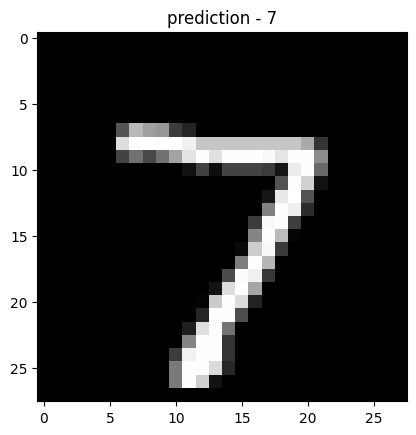

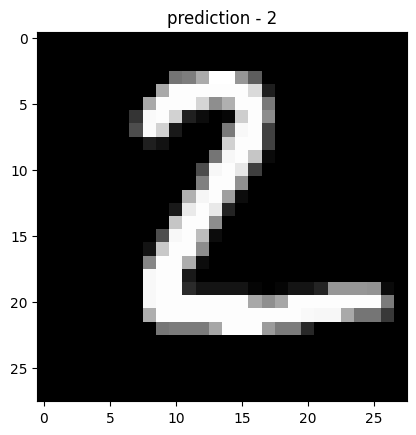

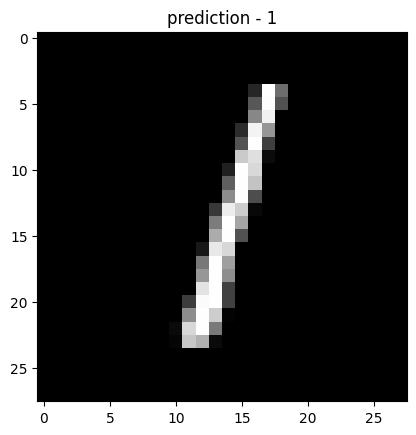

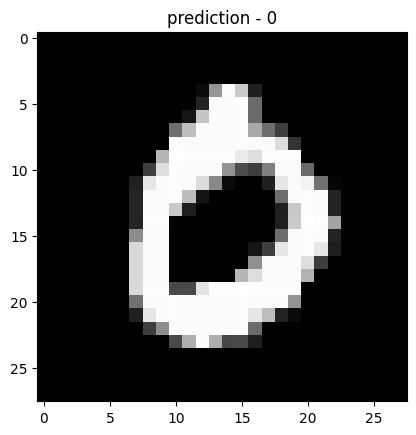

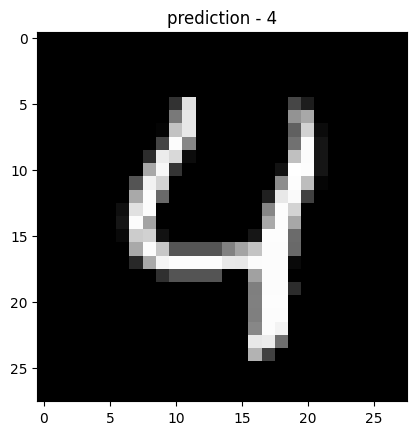

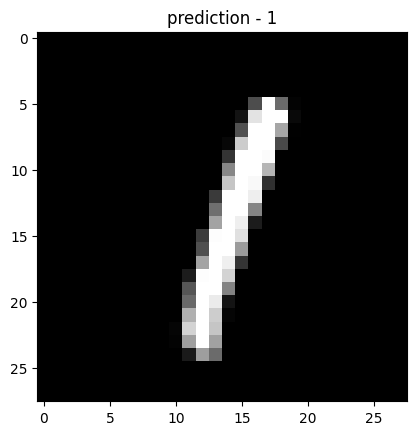

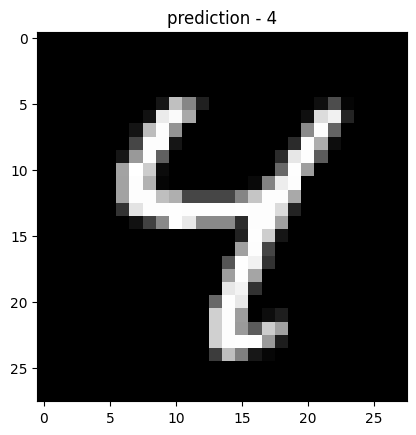

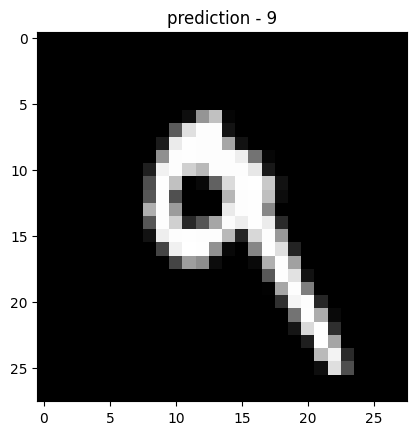

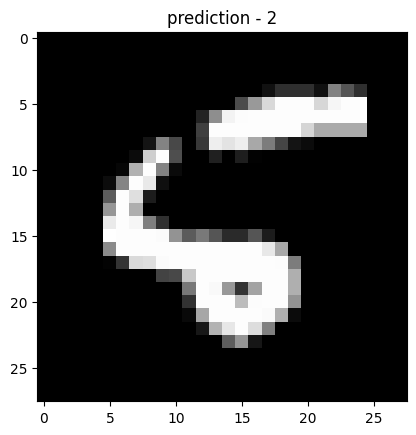

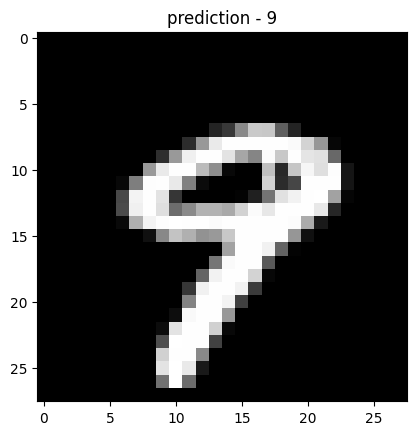

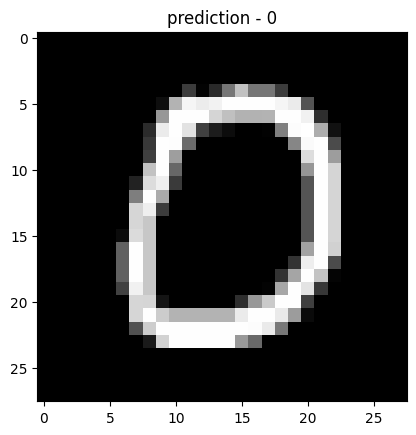

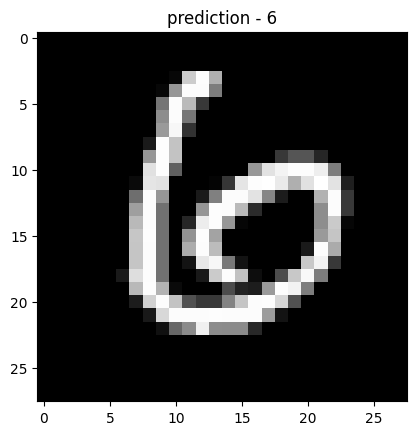

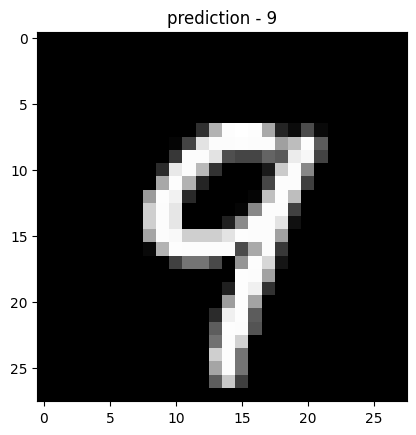

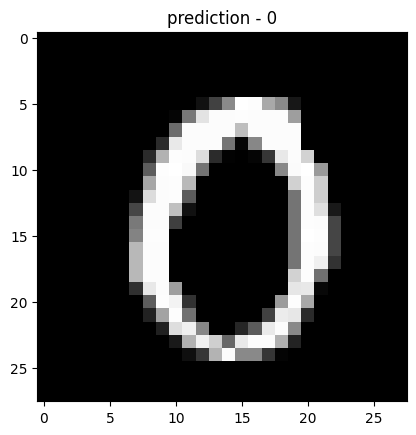

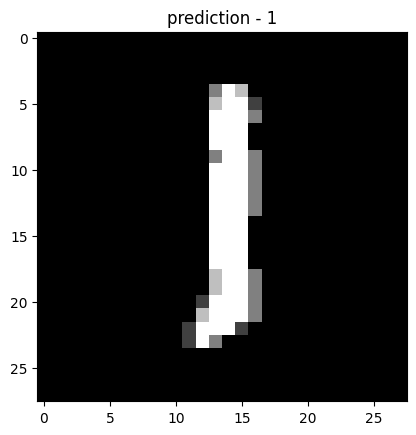

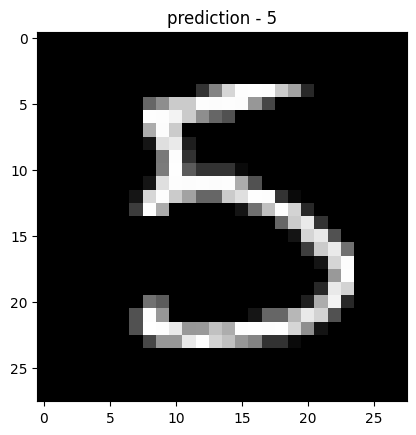

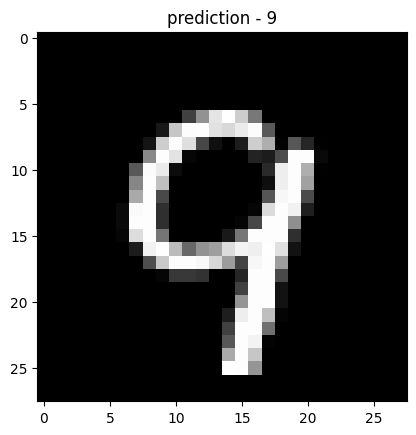

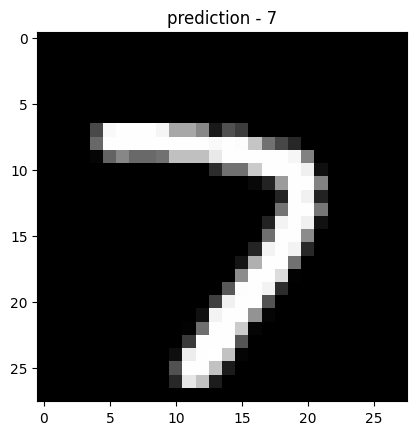

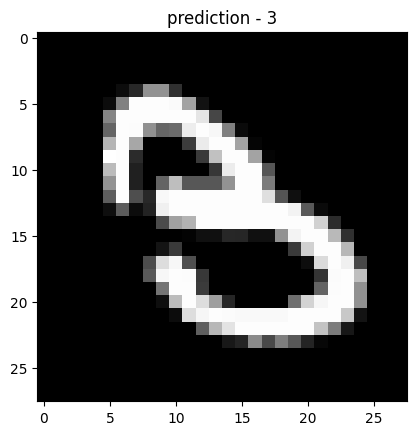

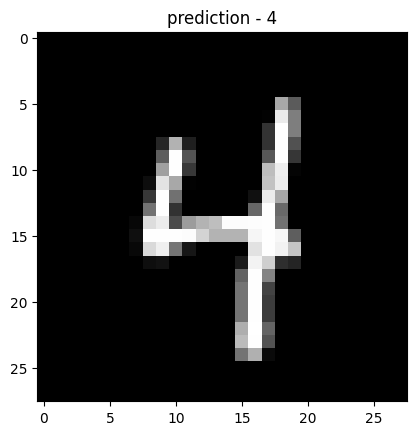

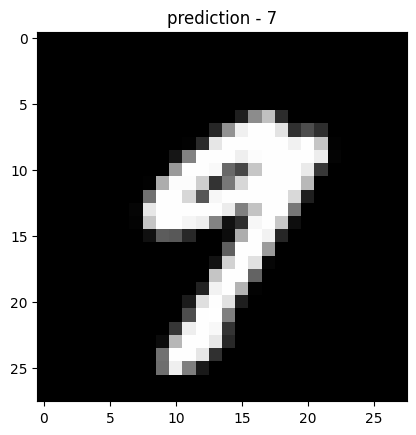

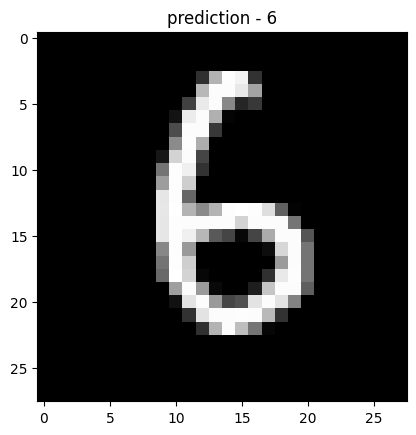

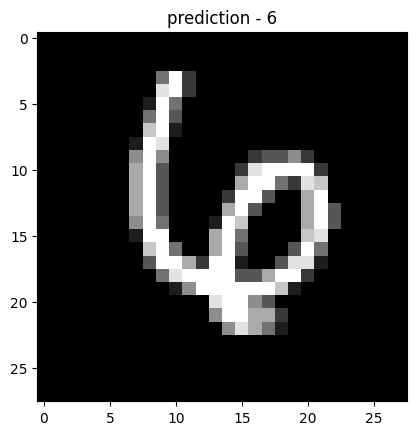

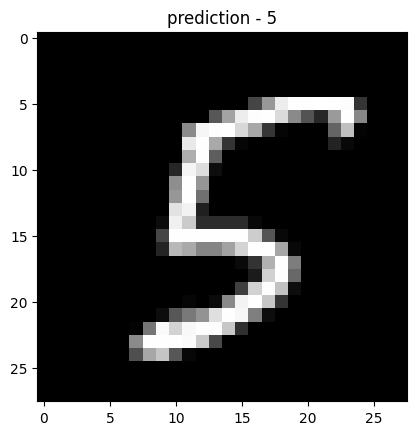

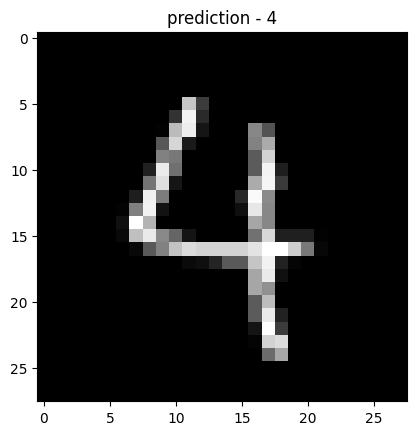

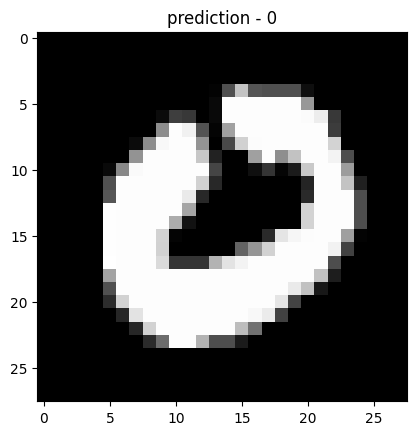

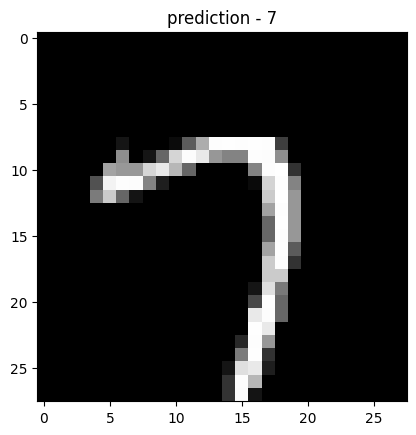

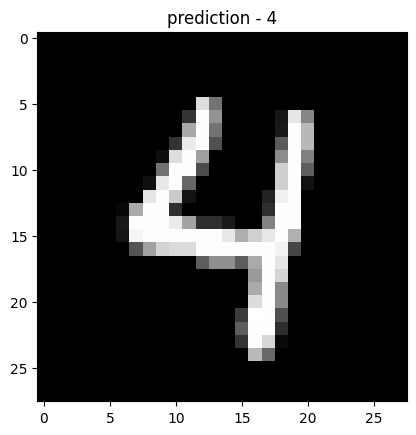

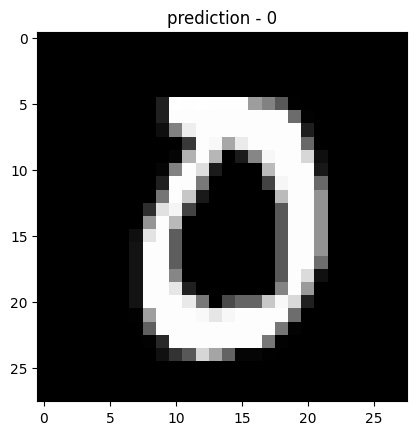

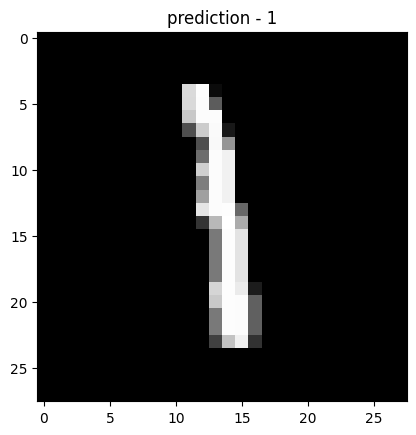

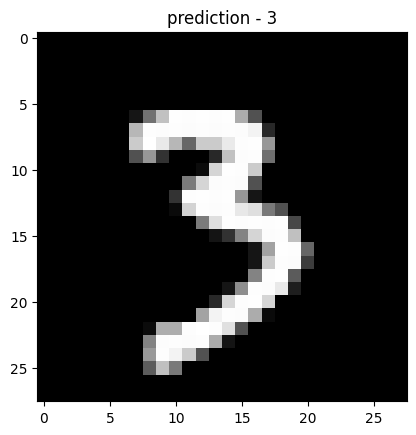

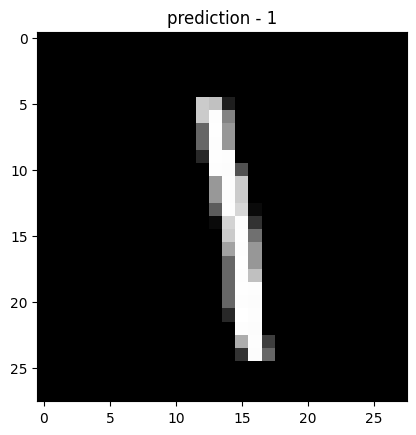

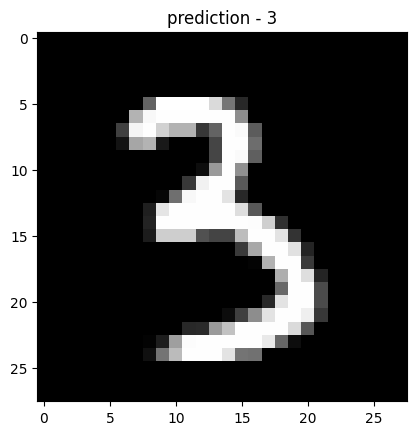

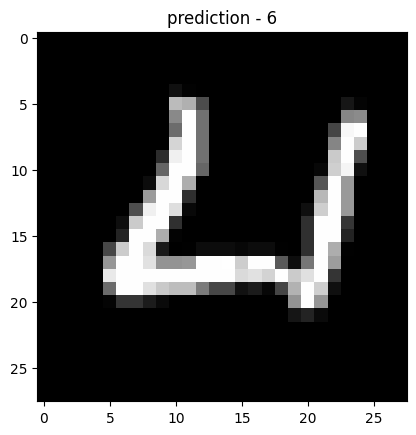

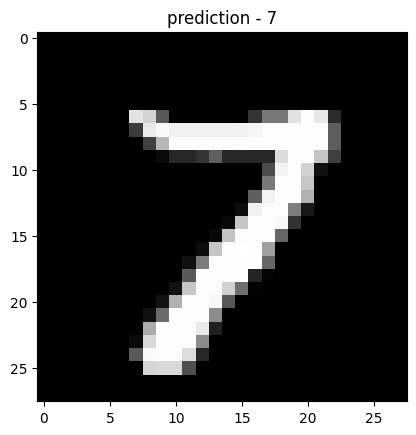

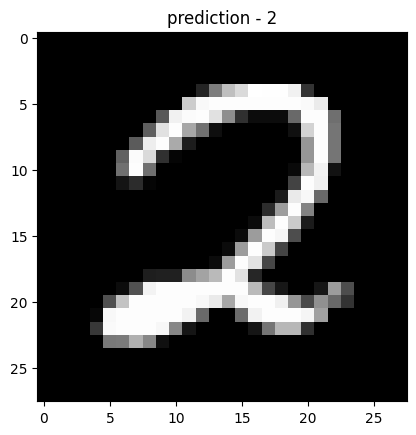

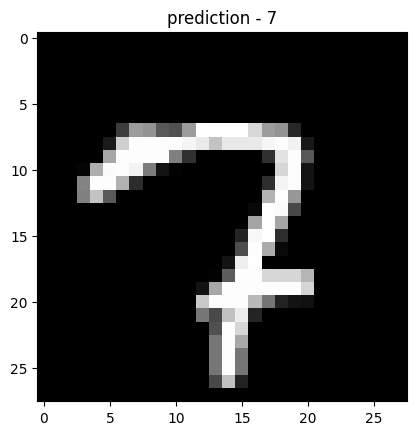

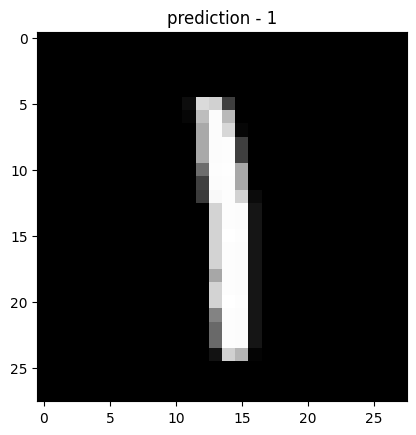

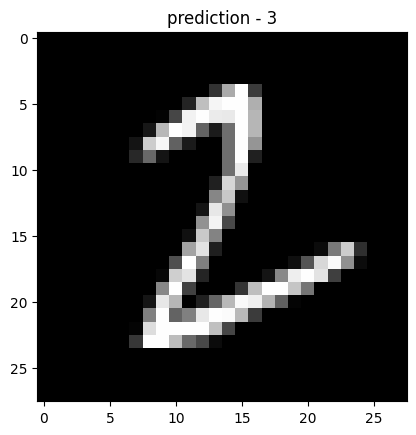

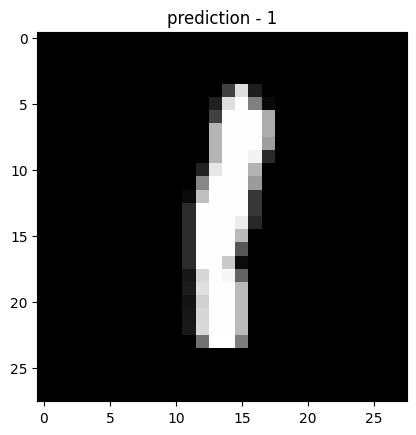

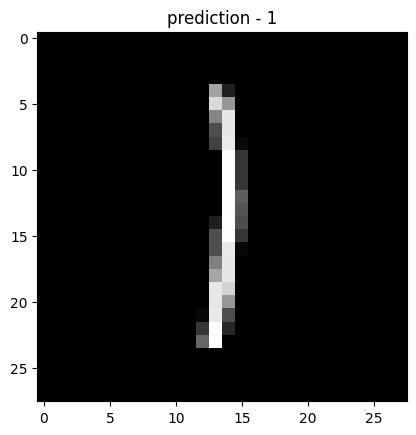

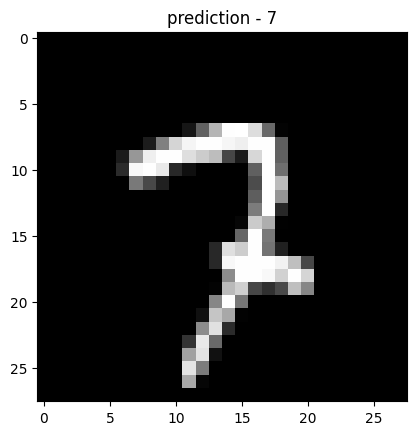

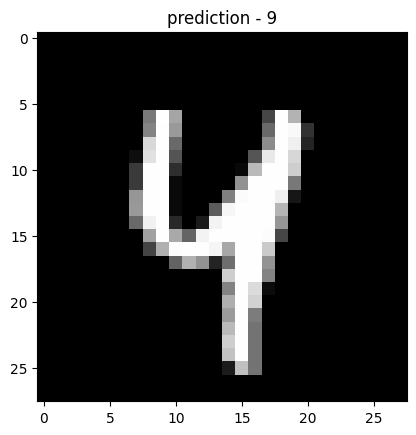

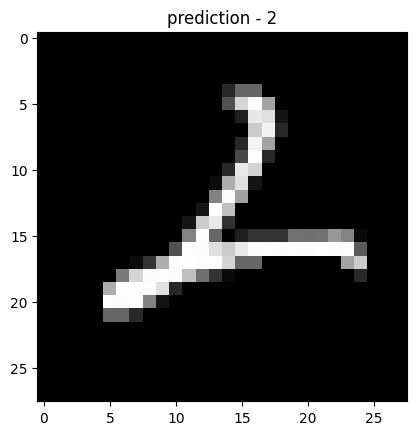

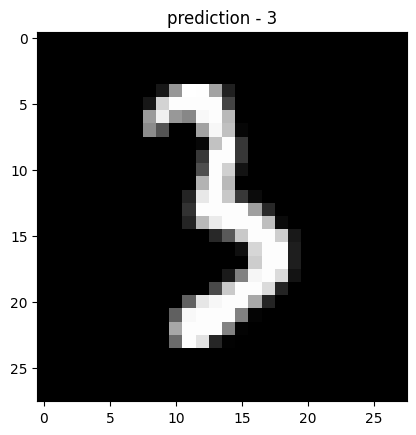

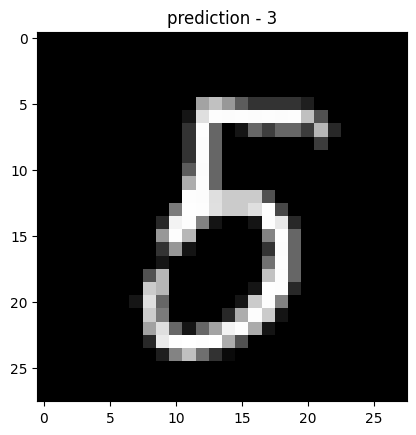

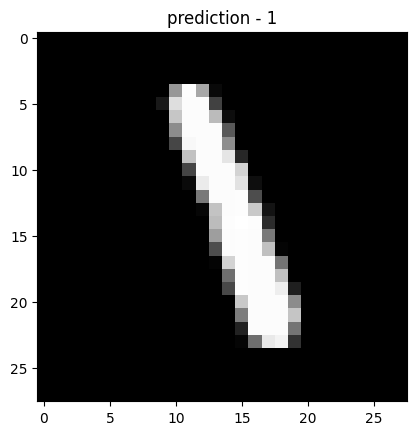

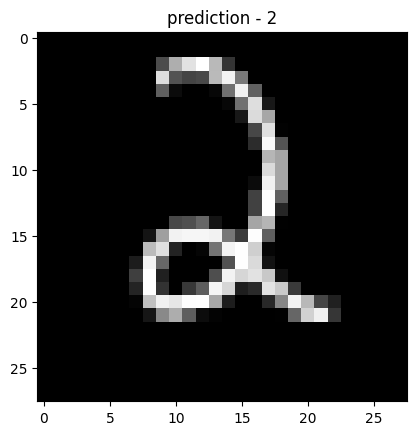

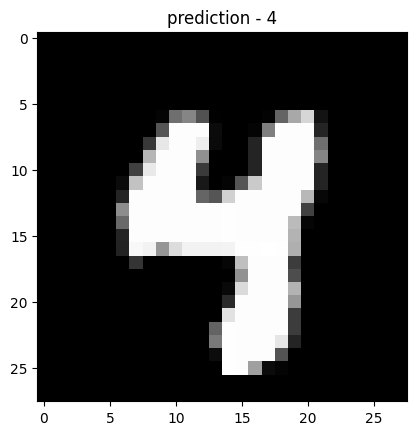

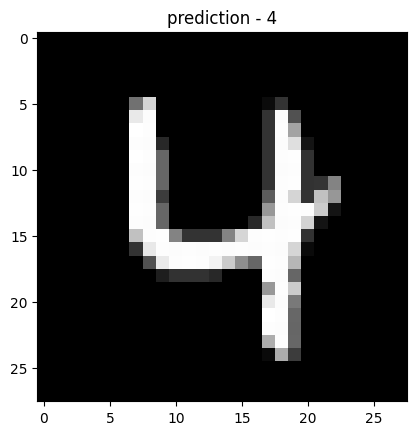

In [ ]:
from matplotlib import pyplot as plt

# summarize loaded dataset
print('Test: X=%s, y=%s' % (X.shape, y.shape))

# plot first few images
for i in range(50):
 # define subplot
#  plt.subplot(340 + 1 + i)
 # plot raw pixel data
 plt.title(f'prediction - {np.argmax(output3[ i , :] )}')
 plt.imshow(X[i].reshape(28,28), cmap=plt.get_cmap('gray'))
 plt.show()
# show the figure
# plt.show()

In [ ]:
accu = np.mean(np.argmax(output3 , axis =1 ) == y)*100
accu

85.54